# Let's Build a Quant Trading Strategy

In [1]:
# signal = model(x)
# orders = strategy(signal)
# execute(orders)

In [2]:
# In the last video, we built a model that predicts what the log return will be eight hours from now.

### type of strategies 

In [3]:
# 1 Maker strategies => they are providing liquidity => adding liquidity to a market and aim to be compensated for it
# 2 Taker strategies => they taking away liquidity => market orders that consume liquidity => what we are going to focus on

In [4]:
# Key Questions for our taking strategy

# 1. Entry/exit timing?
# 2. Trade Size
# 3. Use Leverage?
# 4. Use take-profit orders?
# 5. Use stop-loss orders?



In [5]:
## the key goal is we want to create a strategy that increases profits from the model's edge

### import the libraries

In [6]:
# Data and analysis libraries
import polars as pl                         # Fast dataframes for financial data
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operations
import random


# Machine learning libraries  
import torch                                # PyTorch framework
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms
import research                             # Model building and training utilities


# Visualization and 
import altair as alt                        # Interactive visualization library

# data sources
import binance                              # Binance market data utilities


### research parameters

In [7]:
sym = 'BTCUSDT'
time_interval = '12h'
download_window = 7 * 4 * 7 # roughly 6 months
forecast_horizon = 1
test_size = 0.2

### load the model 

In [8]:
import models
model = models.LinearModel(3)
# security alert 
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

LinearModel(
  (linear): Linear(in_features=3, out_features=1, bias=True)
)

### interpreted as a mean reversion model

In [9]:
series = [-0.014000, 0.011399, -0.012212, 0.01997, -0.01442, 0.01227]
mu = np.mean(series)
mean_reversion_df = pl.DataFrame({'log_return': series, 'mean': mu})
mean_reversion_df

log_return,mean
f64,f64
-0.014,0.000501
0.011399,0.000501
-0.012212,0.000501
0.01997,0.000501
-0.01442,0.000501
0.01227,0.000501


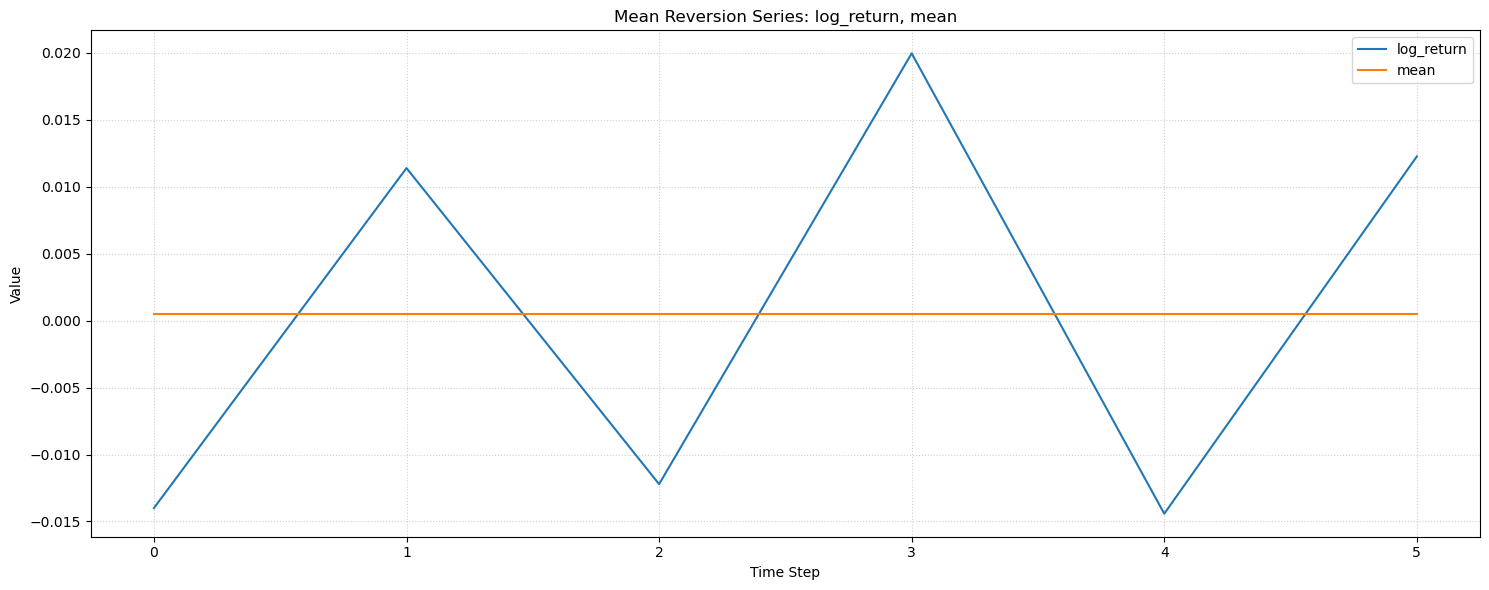

In [10]:
research.plot_multiple_lines(mean_reversion_df, ['log_return','mean'], 'Mean Reversion')

### model parameters

In [11]:
research.print_model_params(model)

linear.weight:
[[-0.10395038 -0.06726477  0.02827305]]
linear.bias:
[0.00067121]


In [12]:
def linear_model(x):
    w, b = -0.09911217, 0.00059838
    return w * x + b

linear_model(-0.015) 

0.00208506255

In [13]:
linear_model(0.02) 

-0.0013838634

In [14]:
linear_model(0.000002)

0.00059818177566

In [15]:
linear_model(0.0)

0.00059838

### interpretability of a neural network

In [16]:

def nn_model(x):
    x = torch.tensor([x])
    W = torch.tensor([0.08035, -0.01478, -0.03523,  0.06777,  0.03789,  0.0013991, -0.13303,  0.8045])
    b = torch.tensor([0.16421])
    return torch.tanh(torch.sum(x * W) + b)

nn_model(-0.015)

tensor([0.1509])

In [17]:
# no interability
nn_model(0.02)

tensor([0.1785])

In [18]:
nn_model(0.0)

tensor([0.1627])

In [19]:
# not disparaging neural networks as my background is neural networks 
# but for trading, neural networks can increase your expected value by a few basis points but at the expense of complexity
# linear models are not sensitive to noise, they are interpretible, less prone to overfit (generalization)

### load time series data

In [20]:
binance.download_trades(sym, download_window)

In [21]:
ts = research.load_ohlc_timeseries(sym, time_interval)
ts

Loading BTCUSDT: 100%|██████████| 346/346 [00:30<00:00, 11.19file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71440.1
2024-10-29 12:00:00,71440.0,73660.0,70900.0,72739.5
2024-10-30 00:00:00,72739.5,72797.4,71931.1,71995.0
2024-10-30 12:00:00,71994.9,72984.9,71444.2,72349.0
2024-10-31 00:00:00,72349.0,72720.3,72030.5,72213.3
…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5


### add log return target and its auto-regressive lags

In [22]:
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=3)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71440.1,null,null,null,null
2024-10-29 12:00:00,71440.0,73660.0,70900.0,72739.5,0.018025,null,null,null
2024-10-30 00:00:00,72739.5,72797.4,71931.1,71995.0,-0.010288,0.018025,null,null
2024-10-30 12:00:00,71994.9,72984.9,71444.2,72349.0,0.004905,-0.010288,0.018025,null
2024-10-31 00:00:00,72349.0,72720.3,72030.5,72213.3,-0.001877,0.004905,-0.010288,0.018025
…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858


### split the time series by time (avoid data leakages)

In [23]:
train_trades, test_trades = research.timeseries_split(ts, test_size)
train_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71440.1,null,null,null,null
2024-10-29 12:00:00,71440.0,73660.0,70900.0,72739.5,0.018025,null,null,null
2024-10-30 00:00:00,72739.5,72797.4,71931.1,71995.0,-0.010288,0.018025,null,null
2024-10-30 12:00:00,71994.9,72984.9,71444.2,72349.0,0.004905,-0.010288,0.018025,null
2024-10-31 00:00:00,72349.0,72720.3,72030.5,72213.3,-0.001877,0.004905,-0.010288,0.018025
…,…,…,…,…,…,…,…,…
2025-07-30 00:00:00,117897.1,118451.3,117291.6,117526.7,-0.003146,-0.005608,0.004384,-0.006518
2025-07-30 12:00:00,117526.6,118763.5,115700.0,117771.0,0.002077,-0.003146,-0.005608,0.004384
2025-07-31 00:00:00,117771.1,118910.0,117713.5,118330.9,0.004743,0.002077,-0.003146,-0.005608


In [24]:
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 12:00:00,115246.5,115956.0,112660.0,113244.8,-0.017522,-0.003903,-0.022508,0.004743
2025-08-02 00:00:00,113244.8,114000.0,113145.0,113732.5,0.004297,-0.017522,-0.003903,-0.022508
2025-08-02 12:00:00,113732.6,113740.5,111910.0,112508.8,-0.010818,0.004297,-0.017522,-0.003903
2025-08-03 00:00:00,112508.8,114200.0,111850.0,113810.1,0.0115,-0.010818,0.004297,-0.017522
2025-08-03 12:00:00,113810.0,114730.0,113529.6,114150.8,0.002989,0.0115,-0.010818,0.004297
…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858


## Strategy Decision #1. What's our entry and exit signal?

In [25]:
# q1: when do we get in? entry signal
# q2: when do we get out? exit signal

In [26]:
# 00:00 -> trade to create a BTCUSDT position based on our prediction
# 08:00 -> trade to close the existing BTCUSDT position, trade to enter a new position on the current log return (00:00 -> 08:00) prediction
# 16:00 -> trade to close the existing BTCUSDT pos, trade to enter a new position on the current log return (08:00 -> 16:00) prediction

In [27]:
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 12:00:00,115246.5,115956.0,112660.0,113244.8,-0.017522,-0.003903,-0.022508,0.004743
2025-08-02 00:00:00,113244.8,114000.0,113145.0,113732.5,0.004297,-0.017522,-0.003903,-0.022508
2025-08-02 12:00:00,113732.6,113740.5,111910.0,112508.8,-0.010818,0.004297,-0.017522,-0.003903
2025-08-03 00:00:00,112508.8,114200.0,111850.0,113810.1,0.0115,-0.010818,0.004297,-0.017522
2025-08-03 12:00:00,113810.0,114730.0,113529.6,114150.8,0.002989,0.0115,-0.010818,0.004297
…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858


### add model's predictions to our trades

In [28]:
target = 'close_log_return'
features = [f'{target}_lag_1',f'{target}_lag_2',f'{target}_lag_3']
X_test = torch.tensor(test_trades[features].to_numpy(), dtype=torch.float32)
# y_hat = model(X_test)
# s = pl.Series('y_hat', y_hat.detach().cpu().numpy().reshape(-1))
# return test_trades.with_columns(s)
X_test

tensor([[-3.9031e-03, -2.2508e-02,  4.7429e-03],
        [-1.7522e-02, -3.9031e-03, -2.2508e-02],
        [ 4.2974e-03, -1.7522e-02, -3.9031e-03],
        [-1.0818e-02,  4.2974e-03, -1.7522e-02],
        [ 1.1500e-02, -1.0818e-02,  4.2974e-03],
        [ 2.9891e-03,  1.1500e-02, -1.0818e-02],
        [ 2.6177e-03,  2.9891e-03,  1.1500e-02],
        [ 4.8123e-03,  2.6177e-03,  2.9891e-03],
        [-1.9157e-03,  4.8123e-03,  2.6177e-03],
        [-6.2259e-03, -1.9157e-03,  4.8123e-03],
        [ 1.0374e-03, -6.2259e-03, -1.9157e-03],
        [ 6.5727e-03,  1.0374e-03, -6.2259e-03],
        [ 1.3207e-02,  6.5727e-03,  1.0374e-03],
        [ 8.1304e-03,  1.3207e-02,  6.5727e-03],
        [-4.9466e-03,  8.1304e-03,  1.3207e-02],
        [-1.8187e-03, -4.9466e-03,  8.1304e-03],
        [ 3.7374e-03, -1.8187e-03, -4.9466e-03],
        [-5.5061e-03,  3.7374e-03, -1.8187e-03],
        [ 1.5967e-02, -5.5061e-03,  3.7374e-03],
        [ 8.0775e-03,  1.5967e-02, -5.5061e-03],
        [ 1.0757e-02

In [29]:
model(X_test).detach().cpu().numpy().squeeze()

array([ 2.7250049e-03,  2.1188434e-03,  1.2927788e-03,  1.0112474e-03,
        3.2494919e-04, -7.1889622e-04,  5.2317360e-04,  7.9397301e-05,
        6.2065473e-04,  1.5833104e-03,  9.2798669e-04, -2.5783834e-04,
       -1.1144528e-03, -8.7648805e-04,  1.0119270e-03,  1.4228638e-03,
        2.6518002e-04,  9.4075553e-04, -5.1250641e-04, -1.3981205e-03,
       -5.3884066e-04,  1.8302501e-03,  2.2016400e-03, -1.0870418e-03,
       -6.7836454e-04, -1.5760434e-03,  1.2643430e-03,  4.9775564e-03,
        1.0226325e-03,  1.1005504e-03,  1.7372308e-03,  2.4564972e-04,
       -1.2351233e-04,  9.3511806e-04,  3.6035783e-03,  7.2172325e-04,
       -2.4977771e-05,  3.8064220e-03,  1.3112662e-03, -1.0002649e-03,
        1.5462687e-03,  2.0694258e-03,  9.4825873e-04, -3.5714016e-03,
       -6.3125888e-04,  2.6579564e-03,  8.1963389e-04,  2.2372843e-03,
        3.3398950e-03,  2.7672471e-03,  9.9215400e-04, -1.2319377e-03,
       -1.1054149e-04,  1.4837570e-03, -9.5451932e-04, -1.7152906e-05,
      

In [30]:
target = 'close_log_return'
features = [f'{target}_lag_1',f'{target}_lag_2',f'{target}_lag_3']
test_trades = research.add_model_predictions(test_trades, model, features)
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32
2025-08-01 12:00:00,115246.5,115956.0,112660.0,113244.8,-0.017522,-0.003903,-0.022508,0.004743,0.002725
2025-08-02 00:00:00,113244.8,114000.0,113145.0,113732.5,0.004297,-0.017522,-0.003903,-0.022508,0.002119
2025-08-02 12:00:00,113732.6,113740.5,111910.0,112508.8,-0.010818,0.004297,-0.017522,-0.003903,0.001293
2025-08-03 00:00:00,112508.8,114200.0,111850.0,113810.1,0.0115,-0.010818,0.004297,-0.017522,0.001011
2025-08-03 12:00:00,113810.0,114730.0,113529.6,114150.8,0.002989,0.0115,-0.010818,0.004297,0.000325
…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933,0.000779
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757,0.003535
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858,0.001011


### add directional signal

In [31]:
test_trades = test_trades.with_columns(pl.col('y_hat').sign().alias('dir_signal'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32
2025-08-01 12:00:00,115246.5,115956.0,112660.0,113244.8,-0.017522,-0.003903,-0.022508,0.004743,0.002725,1.0
2025-08-02 00:00:00,113244.8,114000.0,113145.0,113732.5,0.004297,-0.017522,-0.003903,-0.022508,0.002119,1.0
2025-08-02 12:00:00,113732.6,113740.5,111910.0,112508.8,-0.010818,0.004297,-0.017522,-0.003903,0.001293,1.0
2025-08-03 00:00:00,112508.8,114200.0,111850.0,113810.1,0.0115,-0.010818,0.004297,-0.017522,0.001011,1.0
2025-08-03 12:00:00,113810.0,114730.0,113529.6,114150.8,0.002989,0.0115,-0.010818,0.004297,0.000325,1.0
…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933,0.000779,1.0
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757,0.003535,1.0
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858,0.001011,1.0


### calculate trade log return

In [32]:
test_trades = test_trades.with_columns((pl.col('close_log_return')*pl.col('dir_signal')).alias('trade_log_return'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal,trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64
2025-08-01 12:00:00,115246.5,115956.0,112660.0,113244.8,-0.017522,-0.003903,-0.022508,0.004743,0.002725,1.0,-0.017522
2025-08-02 00:00:00,113244.8,114000.0,113145.0,113732.5,0.004297,-0.017522,-0.003903,-0.022508,0.002119,1.0,0.004297
2025-08-02 12:00:00,113732.6,113740.5,111910.0,112508.8,-0.010818,0.004297,-0.017522,-0.003903,0.001293,1.0,-0.010818
2025-08-03 00:00:00,112508.8,114200.0,111850.0,113810.1,0.0115,-0.010818,0.004297,-0.017522,0.001011,1.0,0.0115
2025-08-03 12:00:00,113810.0,114730.0,113529.6,114150.8,0.002989,0.0115,-0.010818,0.004297,0.000325,1.0,0.002989
…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933,0.000779,1.0,-0.025324
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757,0.003535,1.0,0.012611
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858,0.001011,1.0,0.003347


### calculate cumulative trade log return

In [33]:
test_trades = test_trades.with_columns(pl.col('trade_log_return').cum_sum().alias('cum_trade_log_return'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal,trade_log_return,cum_trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64
2025-08-01 12:00:00,115246.5,115956.0,112660.0,113244.8,-0.017522,-0.003903,-0.022508,0.004743,0.002725,1.0,-0.017522,-0.017522
2025-08-02 00:00:00,113244.8,114000.0,113145.0,113732.5,0.004297,-0.017522,-0.003903,-0.022508,0.002119,1.0,0.004297,-0.013225
2025-08-02 12:00:00,113732.6,113740.5,111910.0,112508.8,-0.010818,0.004297,-0.017522,-0.003903,0.001293,1.0,-0.010818,-0.024043
2025-08-03 00:00:00,112508.8,114200.0,111850.0,113810.1,0.0115,-0.010818,0.004297,-0.017522,0.001011,1.0,0.0115,-0.012543
2025-08-03 12:00:00,113810.0,114730.0,113529.6,114150.8,0.002989,0.0115,-0.010818,0.004297,0.000325,1.0,0.002989,-0.009554
…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933,0.000779,1.0,-0.025324,0.155041
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757,0.003535,1.0,0.012611,0.167652
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858,0.001011,1.0,0.003347,0.170999


### equity curve (log space)

In [34]:
research.plot_column(test_trades, 'cum_trade_log_return')

alt.Chart(...)

### add transaction fees (net returns)

In [35]:
test_trades = research.add_tx_fees(test_trades, binance.MAKER_FEE, binance.TAKER_FEE)
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal,trade_log_return,cum_trade_log_return,tx_fee_log_maker,trade_log_return_net_maker,equity_curve_net_maker,tx_fee_log_taker,trade_log_return_net_taker,equity_curve_net_taker
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 12:00:00,115246.5,115956.0,112660.0,113244.8,-0.017522,-0.003903,-0.022508,0.004743,0.002725,1.0,-0.017522,-0.017522,-0.0002,-0.017722,-0.017722,-0.0006,-0.018123,-0.018123
2025-08-02 00:00:00,113244.8,114000.0,113145.0,113732.5,0.004297,-0.017522,-0.003903,-0.022508,0.002119,1.0,0.004297,-0.013225,-0.0002,0.004097,-0.013625,-0.0006,0.003697,-0.014425
2025-08-02 12:00:00,113732.6,113740.5,111910.0,112508.8,-0.010818,0.004297,-0.017522,-0.003903,0.001293,1.0,-0.010818,-0.024043,-0.0002,-0.011018,-0.024643,-0.0006,-0.011418,-0.025843
2025-08-03 00:00:00,112508.8,114200.0,111850.0,113810.1,0.0115,-0.010818,0.004297,-0.017522,0.001011,1.0,0.0115,-0.012543,-0.0002,0.0113,-0.013343,-0.0006,0.0109,-0.014944
2025-08-03 12:00:00,113810.0,114730.0,113529.6,114150.8,0.002989,0.0115,-0.010818,0.004297,0.000325,1.0,0.002989,-0.009554,-0.0002,0.002789,-0.010554,-0.0006,0.002389,-0.012555
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933,0.000779,1.0,-0.025324,0.155041,-0.0002,-0.025524,0.128039,-0.0006,-0.025924,0.074017
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757,0.003535,1.0,0.012611,0.167652,-0.0002,0.012411,0.140449,-0.0006,0.012011,0.086028
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858,0.001011,1.0,0.003347,0.170999,-0.0002,0.003147,0.143597,-0.0006,0.002747,0.088775


In [36]:
research.plot_column(test_trades, 'cum_trade_log_return')

alt.Chart(...)

In [37]:
research.plot_column(test_trades, 'equity_curve_net_taker')

alt.Chart(...)

In [38]:
research.plot_column(test_trades, 'equity_curve_net_maker')

alt.Chart(...)

## trade sizing

### constant trade value

In [82]:
view_cols = [
    'datetime',
    'open',
    'close_log_return',
    'y_hat',
    'dir_signal',
    'trade_log_return',
    'cum_trade_log_return',
    'trade_value',
    'trade_qty',
    'signed_trade_qty'
]

In [83]:
capital = 100
trade_value = capital
test_trades = test_trades.with_columns(
    pl.lit(trade_value).alias('trade_value'),
    (trade_value / pl.col('open')).alias('trade_qty')
).with_columns(
    (pl.col('trade_qty') * pl.col('dir_signal')).alias('signed_trade_qty')
)

test_trades.select(view_cols)

datetime,open,close_log_return,y_hat,dir_signal,trade_log_return,cum_trade_log_return,trade_value,trade_qty,signed_trade_qty
datetime[μs],f64,f64,f32,f32,f64,f64,i32,f64,f64
2025-08-01 12:00:00,115246.5,-0.017522,0.002725,1.0,-0.017522,-0.017522,100,0.000868,0.000868
2025-08-02 00:00:00,113244.8,0.004297,0.002119,1.0,0.004297,-0.013225,100,0.000883,0.000883
2025-08-02 12:00:00,113732.6,-0.010818,0.001293,1.0,-0.010818,-0.024043,100,0.000879,0.000879
2025-08-03 00:00:00,112508.8,0.0115,0.001011,1.0,0.0115,-0.012543,100,0.000889,0.000889
2025-08-03 12:00:00,113810.0,0.002989,0.000325,1.0,0.002989,-0.009554,100,0.000879,0.000879
…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,-0.025324,0.000779,1.0,-0.025324,0.155041,100,0.000804,0.000804
2025-10-08 00:00:00,121286.6,0.012611,0.003535,1.0,0.012611,0.167652,100,0.000824,0.000824
2025-10-08 12:00:00,122825.8,0.003347,0.001011,1.0,0.003347,0.170999,100,0.000814,0.000814


### add trade gross pnl

In [84]:
test_trades = test_trades.with_columns((pl.col('trade_log_return')*pl.col('trade_value')).alias('trade_gross_pnl'))
if 'trade_gross_pnl' not in view_cols: view_cols.append('trade_gross_pnl')
test_trades.select(view_cols)

datetime,open,close_log_return,y_hat,dir_signal,trade_log_return,cum_trade_log_return,trade_value,trade_qty,signed_trade_qty,trade_gross_pnl
datetime[μs],f64,f64,f32,f32,f64,f64,i32,f64,f64,f64
2025-08-01 12:00:00,115246.5,-0.017522,0.002725,1.0,-0.017522,-0.017522,100,0.000868,0.000868,-1.752233
2025-08-02 00:00:00,113244.8,0.004297,0.002119,1.0,0.004297,-0.013225,100,0.000883,0.000883,0.429735
2025-08-02 12:00:00,113732.6,-0.010818,0.001293,1.0,-0.010818,-0.024043,100,0.000879,0.000879,-1.081776
2025-08-03 00:00:00,112508.8,0.0115,0.001011,1.0,0.0115,-0.012543,100,0.000889,0.000889,1.149983
2025-08-03 12:00:00,113810.0,0.002989,0.000325,1.0,0.002989,-0.009554,100,0.000879,0.000879,0.298911
…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,-0.025324,0.000779,1.0,-0.025324,0.155041,100,0.000804,0.000804,-2.532416
2025-10-08 00:00:00,121286.6,0.012611,0.003535,1.0,0.012611,0.167652,100,0.000824,0.000824,1.261076
2025-10-08 12:00:00,122825.8,0.003347,0.001011,1.0,0.003347,0.170999,100,0.000814,0.000814,0.334711


### add round trip transaction fees

In [87]:
test_trades = test_trades.with_columns((pl.col('trade_value')*2*binance.TAKER_FEE).alias('tx_fees'))
if 'tx_fees' not in view_cols: view_cols.append('tx_fees')
test_trades.select(view_cols)

datetime,open,close_log_return,y_hat,dir_signal,trade_log_return,cum_trade_log_return,trade_value,trade_qty,signed_trade_qty,trade_gross_pnl,tx_fees
datetime[μs],f64,f64,f32,f32,f64,f64,i32,f64,f64,f64,f64
2025-08-01 12:00:00,115246.5,-0.017522,0.002725,1.0,-0.017522,-0.017522,100,0.000868,0.000868,-1.752233,0.06
2025-08-02 00:00:00,113244.8,0.004297,0.002119,1.0,0.004297,-0.013225,100,0.000883,0.000883,0.429735,0.06
2025-08-02 12:00:00,113732.6,-0.010818,0.001293,1.0,-0.010818,-0.024043,100,0.000879,0.000879,-1.081776,0.06
2025-08-03 00:00:00,112508.8,0.0115,0.001011,1.0,0.0115,-0.012543,100,0.000889,0.000889,1.149983,0.06
2025-08-03 12:00:00,113810.0,0.002989,0.000325,1.0,0.002989,-0.009554,100,0.000879,0.000879,0.298911,0.06
…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,-0.025324,0.000779,1.0,-0.025324,0.155041,100,0.000804,0.000804,-2.532416,0.06
2025-10-08 00:00:00,121286.6,0.012611,0.003535,1.0,0.012611,0.167652,100,0.000824,0.000824,1.261076,0.06
2025-10-08 12:00:00,122825.8,0.003347,0.001011,1.0,0.003347,0.170999,100,0.000814,0.000814,0.334711,0.06


### calculate trade net pnl

In [91]:
test_trades = test_trades.with_columns((pl.col('trade_gross_pnl')-pl.col('tx_fees')).alias('trade_net_pnl'))
if 'trade_net_pnl' not in view_cols: view_cols.append('trade_net_pnl')
test_trades.select(view_cols)

datetime,open,close_log_return,y_hat,dir_signal,trade_log_return,cum_trade_log_return,trade_value,trade_qty,signed_trade_qty,trade_gross_pnl,tx_fees,trade_net_pnl
datetime[μs],f64,f64,f32,f32,f64,f64,i32,f64,f64,f64,f64,f64
2025-08-01 12:00:00,115246.5,-0.017522,0.002725,1.0,-0.017522,-0.017522,100,0.000868,0.000868,-1.752233,0.06,-1.812233
2025-08-02 00:00:00,113244.8,0.004297,0.002119,1.0,0.004297,-0.013225,100,0.000883,0.000883,0.429735,0.06,0.369735
2025-08-02 12:00:00,113732.6,-0.010818,0.001293,1.0,-0.010818,-0.024043,100,0.000879,0.000879,-1.081776,0.06,-1.141776
2025-08-03 00:00:00,112508.8,0.0115,0.001011,1.0,0.0115,-0.012543,100,0.000889,0.000889,1.149983,0.06,1.089983
2025-08-03 12:00:00,113810.0,0.002989,0.000325,1.0,0.002989,-0.009554,100,0.000879,0.000879,0.298911,0.06,0.238911
…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,-0.025324,0.000779,1.0,-0.025324,0.155041,100,0.000804,0.000804,-2.532416,0.06,-2.592416
2025-10-08 00:00:00,121286.6,0.012611,0.003535,1.0,0.012611,0.167652,100,0.000824,0.000824,1.261076,0.06,1.201076
2025-10-08 12:00:00,122825.8,0.003347,0.001011,1.0,0.003347,0.170999,100,0.000814,0.000814,0.334711,0.06,0.274711


### equity curve

In [ ]:
test_trades = test_trades.with_columns(initial_capital+(pl.col('trade_net_pnl').cum_sum()).alias('trade_net_pnl'))
if 'trade_net_pnl' not in view_cols: view_cols.append('trade_net_pnl')
test_trades.select(view_cols)

In [ ]:
# topics we haven't covered
# alpha decay (also known as model drift) => where the performance drifts => 
# market impact => we are not trading big sizes => if we were, we could potentially move markets against us
# funding fees/rebates
# slippage => we may not always get the best price, we may get executed at prices below top of the book (best bid/ask)

# spread => BTCUSDT has quite tight spreads => so we have nominal spread costs